In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

In [2]:
FPATH = "../../data/sampling_results/Benchmark-15/"

function marg_mean_shaped(name)
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = mean(smpl_tmp)
    return smpl_tmp
end

function marg_std_shaped(name)
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = std(smpl_tmp)
    return smpl_tmp
end

function get_emmitance_halo(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[proj,:].*smpl_tmp[2+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

function get_emmitance_core(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name).result
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[1+proj,:].*smpl_tmp[3+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

get_emmitance_core (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.0077
β3 = 0.0058

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), ],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), ],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), ],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), ],
        mixt_pow =  0.35 .. 1.0, 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.47799, 15.025999, 23.1644],
);


labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", "res x", "res y", "la", "la", "la"];

In [4]:
smpl_tmp = bat_read(FPATH*"hc-167.hdf5").result
smpl_tmp = varshape(prior).(smpl_tmp);

In [5]:
filenames = readdir("../../data/sampling_results/Benchmark-15/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [6]:
filenames = readdir("../../data/sampling_results/Benchmark-15/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [7]:
fnames = [lc_fnames; hc_fnames]
charges = Float64[lc_charge; hc_charge]
runind = Int64[lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [8]:
length(fnames)

48

In [9]:
mean_params =  [marg_mean_shaped(i) for i in fnames];
std_params =  [marg_std_shaped(i) for i in fnames];

In [10]:
tr_size = [i.tr_size[1] for i in mean_params]
ang_spread = [i.ang_spr[1] for i in mean_params]
waist = [i.waist[1] for i in mean_params]
cam4_resx = [i.cam4_resx[1] for i in mean_params]
cam4_resy = [i.cam4_resy[1] for i in mean_params];

In [17]:
tr_size_2 = [i.tr_size_2[1] for i in mean_params]
ang_spread_2 = [i.ang_spr_2[1] for i in mean_params]
waist_2 = [i.waist_2[1] for i in mean_params]
mixt_pow = [i.mixt_pow[1] for i in mean_params]

48-element Vector{Float64}:
 0.7370789496713758
 0.7573350183328764
 0.6367273508178242
 0.7199425578218237
 0.7389841605729941
 0.7025967180439074
 0.626897347203698
 0.7359667321374825
 0.6739390795197897
 0.649109419947717
 0.7204851430543588
 0.7142436125557154
 0.7206172744324795
 ⋮
 0.6965041945989134
 0.6344507484783048
 0.6785662634899454
 0.5937742691790472
 0.6268274042173905
 0.7360915980432693
 0.728161061025752
 0.5865942571991454
 0.6263991298890927
 0.6882500770860709
 0.656096374583077
 0.7326269131074749

In [12]:
@show mean(tr_size),  mean(ang_spread),  mean(waist),  mean(cam4_resx), mean(tr_size_2),  mean(ang_spread_2),  mean(waist_2)

(mean(tr_size), mean(ang_spread), mean(waist), mean(cam4_resx), mean(tr_size_2), mean(ang_spread_2), mean(waist_2)) = (0.08853616252446339, 5.8680827745070365, 3.2617433014619084, 4.979667623211525, 0.12934944668351597, 2.380523895895156, 2.7509477898197403)


(0.08853616252446339, 5.8680827745070365, 3.2617433014619084, 4.979667623211525, 0.12934944668351597, 2.380523895895156, 2.7509477898197403)

In [18]:
mean(mixt_pow)

0.6887016851438134

In [13]:
mean(charges)

25.885435541470844

In [14]:
emm_tmp_1 = [get_emmitance_halo(i, 1).mean for i in fnames]

mean(emm_tmp_1)

2.206705116798681

In [15]:
emm_tmp_2 = [get_emmitance_core(i, 1).mean for i in fnames]

mean(emm_tmp_2)

1.3120224214298208

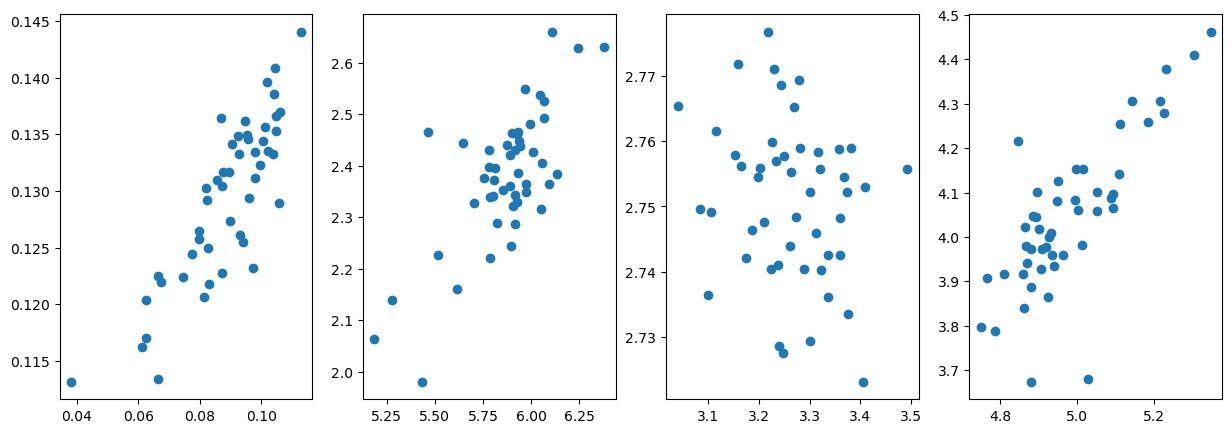

PyObject <matplotlib.collections.PathCollection object at 0x7fe94c097310>

In [16]:
fig, ax= plt.subplots(1,4, figsize=(15,5))

ax[1].scatter(tr_size, tr_size_2)
ax[2].scatter(ang_spread, ang_spread_2)
ax[3].scatter(waist, waist_2)
ax[4].scatter(cam4_resx, cam4_resy)